Computing scalar coefficients: 100%|██████████| 30/30 [00:00<00:00, 189.79it/s]


✓ Saved vertical coefficients → input_features/avg_scalar_params/avg_weight_and_biases_building649.csv
✓ Saved vertical coefficients → input_features/avg_scalar_params/avg_weight_and_biases_building821.csv
✓ Saved vertical coefficients → input_features/avg_scalar_params/avg_weight_and_biases_building1241.csv
✓ Saved vertical coefficients → input_features/avg_scalar_params/avg_weight_and_biases_building259.csv
✓ Saved vertical coefficients → input_features/avg_scalar_params/avg_weight_and_biases_building493.csv
✓ Saved vertical coefficients → input_features/avg_scalar_params/avg_weight_and_biases_building535.csv
✓ Saved vertical coefficients → input_features/avg_scalar_params/avg_weight_and_biases_building1325.csv
✓ Saved vertical coefficients → input_features/avg_scalar_params/avg_weight_and_biases_building1691.csv
✓ Saved vertical coefficients → input_features/avg_scalar_params/avg_weight_and_biases_building1972.csv
✓ Saved vertical coefficients → input_features/avg_scalar_params/avg_

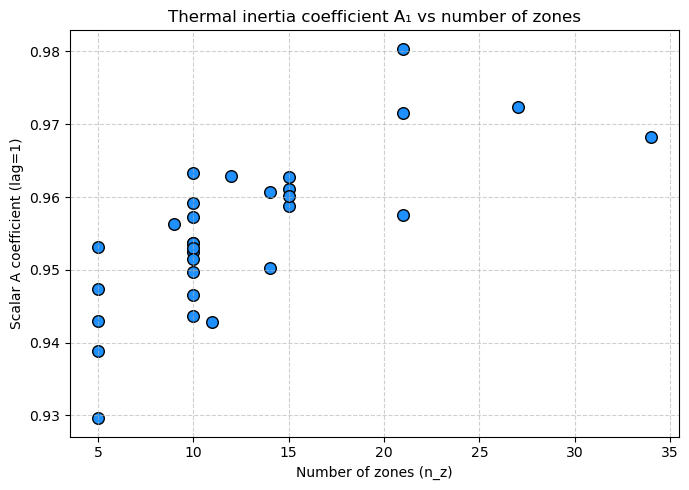

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from src.utils import load_armax_model

# =====================================================
# CONFIGURATION
# =====================================================
base_path = os.path.join('armax_models', 'archetypes')
output_dir = os.path.join('input_features', 'avg_scalar_params')
os.makedirs(output_dir, exist_ok=True)

BUILDING_IDS = [
    "ep_SFH_age_0_climate_0_649", "ep_SFH_age_0_climate_0_821", "ep_SFH_age_0_climate_0_1241",
    "ep_SFH_age_0_climate_1_259", "ep_SFH_age_0_climate_1_493", "ep_SFH_age_0_climate_1_535",
    "ep_SFH_age_0_climate_2_1325", "ep_SFH_age_0_climate_2_1691", "ep_SFH_age_0_climate_2_1972",
    "ep_SFH_age_0_climate_3_955", "ep_SFH_age_0_climate_3_1081", "ep_SFH_age_0_climate_3_1123",
    "ep_SFH_age_0_climate_4_1072", "ep_SFH_age_0_climate_4_1688", "ep_SFH_age_0_climate_4_1709",
    "ep_SFH_age_0_climate_5_417", "ep_SFH_age_0_climate_5_758", "ep_SFH_age_0_climate_5_928",
    "ep_SFH_age_1_climate_0_42", "ep_SFH_age_1_climate_0_168", "ep_SFH_age_1_climate_0_249",
    "ep_SFH_age_1_climate_1_32", "ep_SFH_age_1_climate_1_429", "ep_SFH_age_1_climate_1_458",
    "ep_SFH_age_1_climate_2_762", "ep_SFH_age_1_climate_2_852", "ep_SFH_age_1_climate_2_1161",
    "ep_SFH_age_1_climate_3_260", "ep_SFH_age_1_climate_3_451", "ep_SFH_age_1_climate_3_597"
]

# =====================================================
# FUNCTION — Compute averaged scalar coefficients
# =====================================================
def compute_avg_armax(armax_config):
    coef         = armax_config["armax_coef"]
    n_z          = armax_config["n_zones"]
    feat_length  = armax_config["feat_length"]
    lags         = armax_config["dynamics_lags_list"]
    pos_T1       = armax_config["pos_T1"]
    pos_u1       = armax_config["pos_u1"]
    pos_T_amb    = armax_config["pos_T_amb"]
    pos_s1       = armax_config["pos_s1"]
    solar_terms  = armax_config["solar_terms"]
    intercept    = armax_config["armax_intercept"].reshape(-1)

    Abar, Bbar, cbar, Dbar = {}, {}, {}, {}
    for i, lag in enumerate(lags):
        idx  = i * feat_length
        Ablk = coef[idx + pos_T1 : idx + pos_T1 + n_z, :]
        Bblk = coef[idx + pos_u1 : idx + pos_u1 + n_z, :]
        cblk = coef[idx + pos_T_amb, :]
        Dblk = coef[idx + pos_s1 : idx + pos_s1 + solar_terms, :]

        Abar[lag] = Ablk.sum() / n_z
        Bbar[lag] = Bblk.sum() / n_z
        cbar[lag] = cblk.sum() / n_z
        Dbar[lag] = (Dblk.sum(axis=1) / n_z)

    bbar = intercept.mean()

    return {"A": Abar, "B": Bbar, "c": cbar, "D": Dbar, "b": bbar,
            "lags": lags, "solar_terms": solar_terms, "n_zones": n_z}

# =====================================================
# MAIN LOOP — Process all buildings
# =====================================================
records = []

for building_id in tqdm(BUILDING_IDS, desc="Computing scalar coefficients"):
    building_num = building_id.split('_')[-1]
    building_folder = os.path.join(base_path, building_id)

    try:
        armax_config = load_armax_model(building_folder_path=building_folder, steps_per_hour=4)
        avg_params = compute_avg_armax(armax_config)

        n_z = avg_params["n_zones"]
        b   = avg_params["b"]
        lags = avg_params["lags"]
        n_solar = avg_params["solar_terms"]

        # ---------------------------------------------
        # 1 GLOBAL SUMMARY DICT (wide format)
        # ---------------------------------------------
        feature_dict = {
            "building_id": building_id,
            "building_num": building_num,
            "n_zones": n_z,
            "b": b
        }

        for lag in lags:
            feature_dict[f"A_lag{lag}"] = avg_params["A"][lag]
            feature_dict[f"B_lag{lag}"] = avg_params["B"][lag]
            feature_dict[f"c_lag{lag}"] = avg_params["c"][lag]
            for j in range(n_solar):
                feature_dict[f"D_lag{lag}_s{j+1}"] = avg_params["D"][lag][j]

        records.append(feature_dict)

        # ---------------------------------------------
        # 2 INDIVIDUAL (62×1) COLUMN FILE
        # ---------------------------------------------
        coeffs = [b]
        for lag in lags:
            coeffs += [avg_params["A"][lag], avg_params["B"][lag], avg_params["c"][lag]]
            coeffs += list(avg_params["D"][lag].ravel())

        coeffs = np.array(coeffs).reshape(-1, 1)
        coeffs = np.vstack(([f"building{building_num}"], coeffs))  # prepend ID

        file_path = os.path.join(output_dir, f"avg_weight_and_biases_building{building_num}.csv")
        pd.DataFrame(coeffs).to_csv(file_path, index=False, header=False)
        print(f"✓ Saved vertical coefficients → {file_path}")

    except Exception as e:
        print(f"⚠️ Error processing {building_id}: {e}")
        continue

# =====================================================
# SAVE GLOBAL SUMMARY TABLE (61 coefficients per row)
# =====================================================
df = pd.DataFrame(records)
csv_path = os.path.join(output_dir, "avg_scalar_armax_61coeff_summary.csv")
df.to_csv(csv_path, index=False)
print(f"\n Saved structured summary table → {csv_path}")

# =====================================================
# SCATTER PLOT — A_lag1 vs n_zones
# =====================================================
if "A_lag1" in df.columns:
    plt.figure(figsize=(7,5))
    plt.scatter(df["n_zones"], df["A_lag1"], c='dodgerblue', edgecolor='k', s=70)
    plt.xlabel("Number of zones (n_z)")
    plt.ylabel("Scalar A coefficient (lag=1)")
    plt.title("Thermal inertia coefficient A₁ vs number of zones")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "A1_vs_nzones.png"), dpi=300)
    plt.show()
else:
    print("⚠️ A_lag1 column not found in summary table — check lag keys.")
